# Credit Card Default

For this analysis, we will use the Credit Card Default dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients). In this case, we will apply a Weight of Evidence (WOE) approach to generate a scorecard for each client.

#### Importing the necessary libraries for the analysis.

In [ ]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks, ScorecardMonitoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings("ignore")

#### Extract the credit card default dataset.

In [369]:
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 

name_map = default_of_credit_card_clients.variables.set_index('name')['description'].to_dict()

X = X.rename(columns=name_map)
X = X.reset_index()
y = y.rename(columns=name_map)
y = y.reset_index()

df = X.merge(y, on='index', how='inner')
df = df.rename(columns={'index': 'ID'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,1,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,4,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### There are 25 variables:
- **ID**: ID of each client
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- **SEX**: Gender (1=male, 2=female)
- **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
- **AGE**: Age in years
- **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- **PAY_2**: Repayment status in August, 2005 (scale same as above)
- **PAY_3**: Repayment status in July, 2005 (scale same as above)
- **PAY_4**: Repayment status in June, 2005 (scale same as above)
- **PAY_5**: Repayment status in May, 2005 (scale same as above)
- **PAY_6**: Repayment status in April, 2005 (scale same as above)
- **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)
- **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)
- **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)
- **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)
- **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)
- **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)
- **PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)
- **PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)
- **PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)
- **PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)
- **PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)
- **PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)
- **default.payment.next.month**: Default payment (1=yes, 0=no)

## Data Exploration

In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

There are no null values reported in any variable, but not all variables have the correct data type.

In [371]:
df = df.drop(columns=['ID'], axis=1)

In [372]:
yT_0 = df['default payment next month'].value_counts(normalize=True)[0]
yT_1 = df['default payment next month'].value_counts(normalize=True)[1]
print(yT_0, yT_1)

0.7788 0.2212


We can see that, given the values of the target variable, the probability of incurring in default payment the following month is around 22%. 

Remember that we will try to predict this variable, so at some point we will examine its relationship with the other variables.

Considering the variable descriptions provided by the [UCI dataset](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients), we will cast some variables to the categorical type.

In [373]:
col_categorys = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','default payment next month']

for i in col_categorys:
    df[i] = df[i].astype('category')

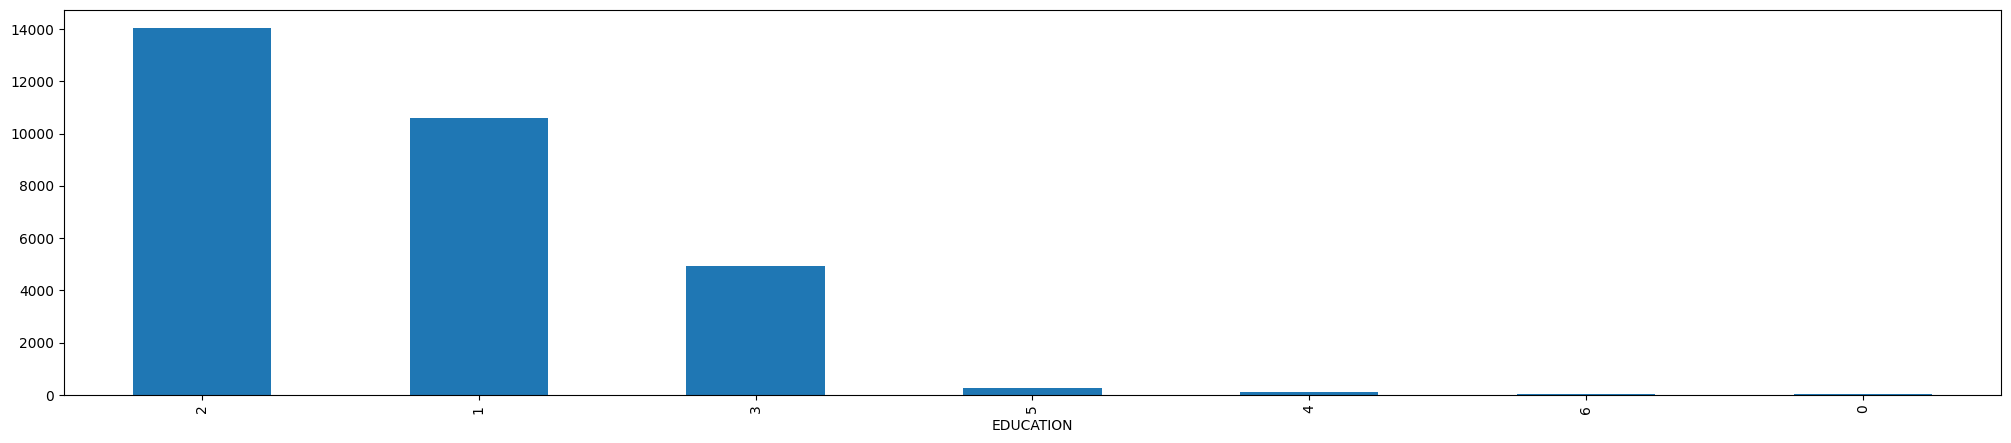

In [374]:
plt.figure(figsize=(25,5))
df['EDUCATION'].value_counts().plot(kind = 'bar')
plt.show()

We see values such as 0, 5, and 6. The value 0 is not listed as a category in the dataset description. Although the values 5 and 6 are described, they are represented as 'Unknown'. Since these cases are few, we will assign them to category 4, which corresponds to 'Others'.

Let’s recall that the purpose of the chi² contingency test is to evaluate whether the variables are independent.

Where:

* $H_0$: The two categorical variables are independent.

Thus, we look to reject the null hypothesis when the p-value is less than the significance level α (usually 0.05)."

In [375]:
print(f"P-Value: {chi2_contingency(pd.crosstab(df['EDUCATION'],df['default payment next month'],margins=True).round(3))[1]}")

P-Value: 1.5987086709565762e-27


Additionally, by crossing the EDUCATION variable with the target variable in a chi-square contingency test, we see that the two categorical variables are not independent, given the p-value. After we reassign the categories, we will check whether the p-value decreases.

We repeat a similar process with the other categorical variables.

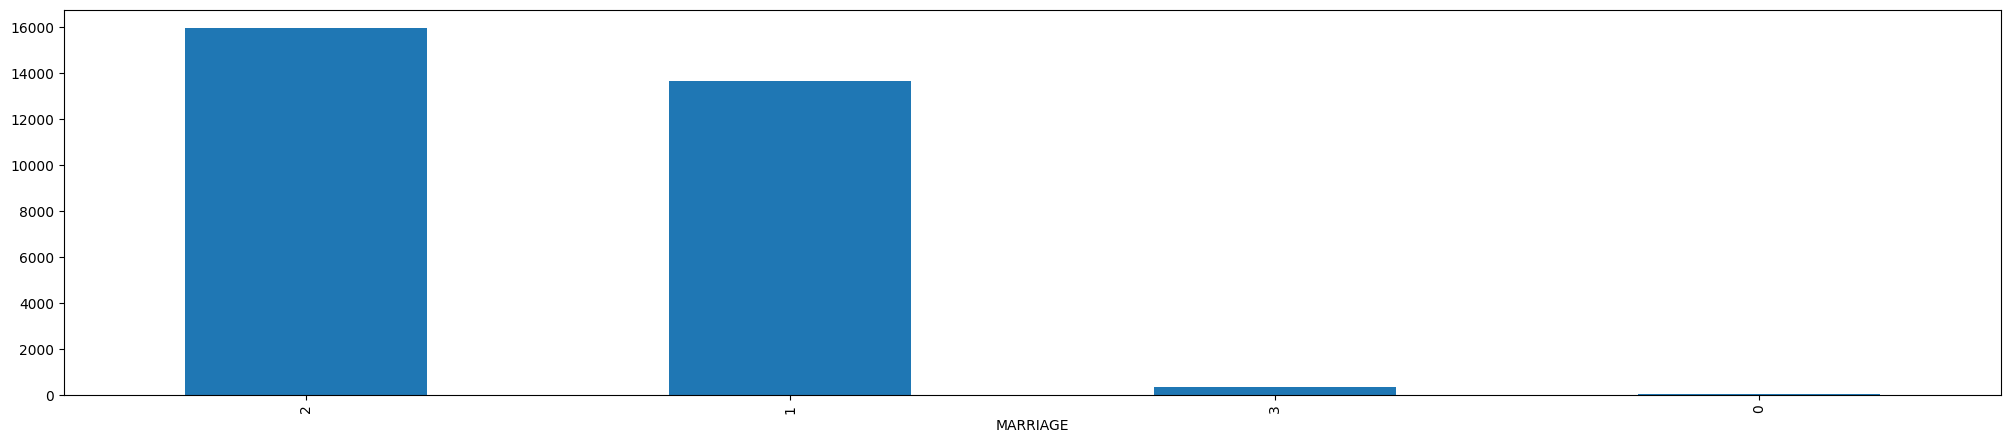

In [376]:
plt.figure(figsize=(25,5))
df['MARRIAGE'].value_counts().plot(kind = 'bar')
plt.show()

We observe the value 0, which is not listed as a category in the dataset description. Given that these cases are few, we will reassign them to category 3, corresponding to 'Others'.

In [377]:
print(f"P-Value: {chi2_contingency(pd.crosstab(df['MARRIAGE'],df['default payment next month'],margins=True).round(3))[1]}")

P-Value: 2.024320753695656e-05


Again, we will check the p-value after the reassignment of the category.

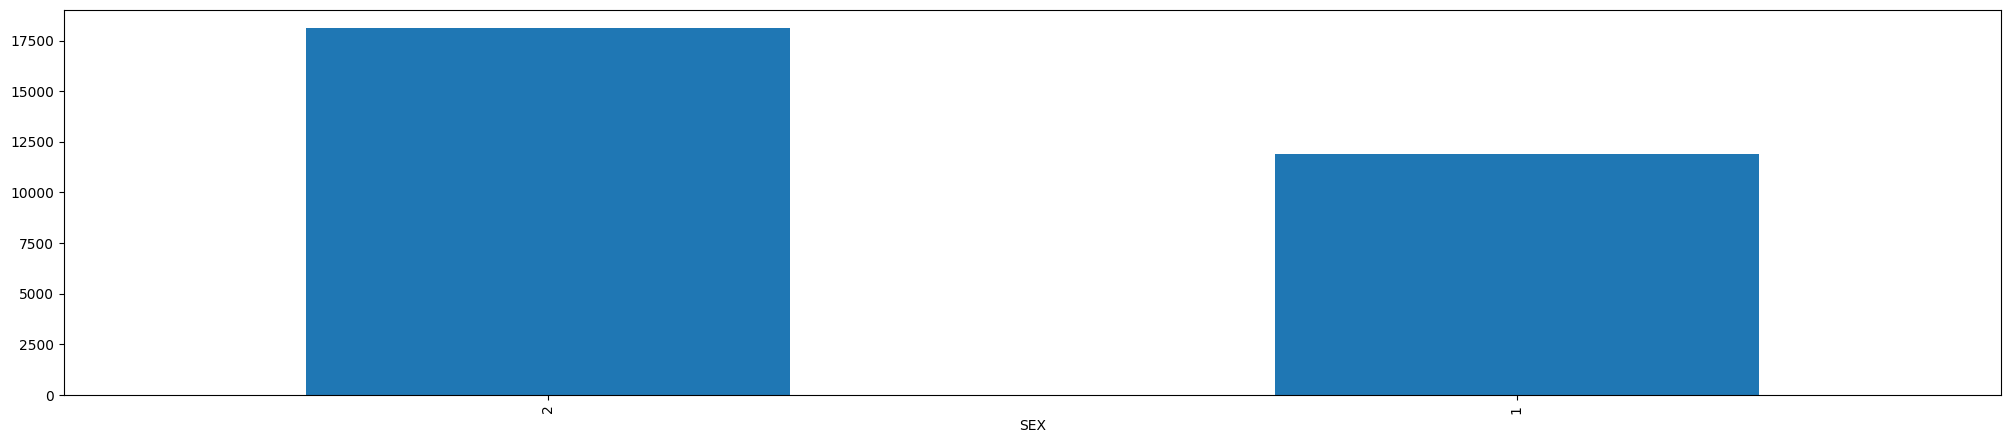

In [378]:
plt.figure(figsize=(25,5))
df['SEX'].value_counts().plot(kind = 'bar')
plt.show()

We do not observe any anomalies in the categories of the SEX variable.

For the variables PAY_N (0, 2, 3, 4, 5, 6), we will use the following function to plot their bar charts, allowing us to quickly check the categories of each variable.

In [379]:
def draw_barplots(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(20, 8))
    
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        counts = df[var_name].value_counts().sort_index()
        
        ax.bar(counts.index.astype(str), counts.values)
        
        ax.set_title(var_name)
        ax.set_xlabel(var_name)
        ax.set_ylabel("Frecuencia")
    
    fig.tight_layout()
    plt.show()


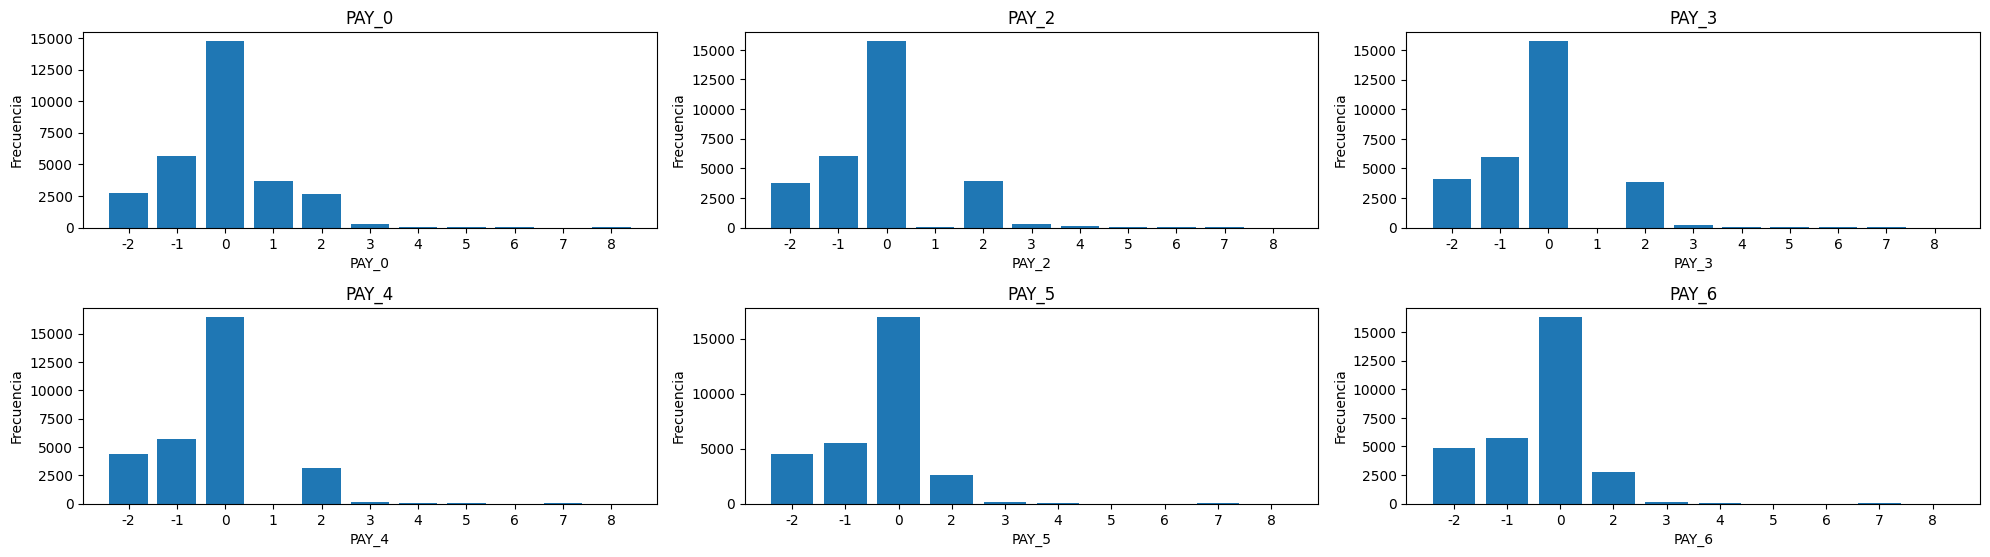

In [380]:
draw_barplots(df,['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],3,3 )

In these variables, we observe the categories -2 and 0, which are not listed in the dataset description. To improve interpretability, we will assign these categories to 0, meaning they will be represented as 'Pay duly'. Additionally, we will rename the column PAY_0 to PAY_1.

### Numerical Variables

We will use this function to plot the histograms of each numerical variable in order to examine their distribution and check their skewness

In [381]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20, 8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(ax=ax)

        ax.axvline(df[var_name].mean(), color='red', linestyle='--', linewidth=2)
        ax.axvline(df[var_name].median(), color='green', linestyle='-', linewidth=2)

        ax.set_title(var_name)
        ax.legend(title=f'Skew: {df[var_name].skew():.2f}')
    fig.tight_layout()
    plt.show()

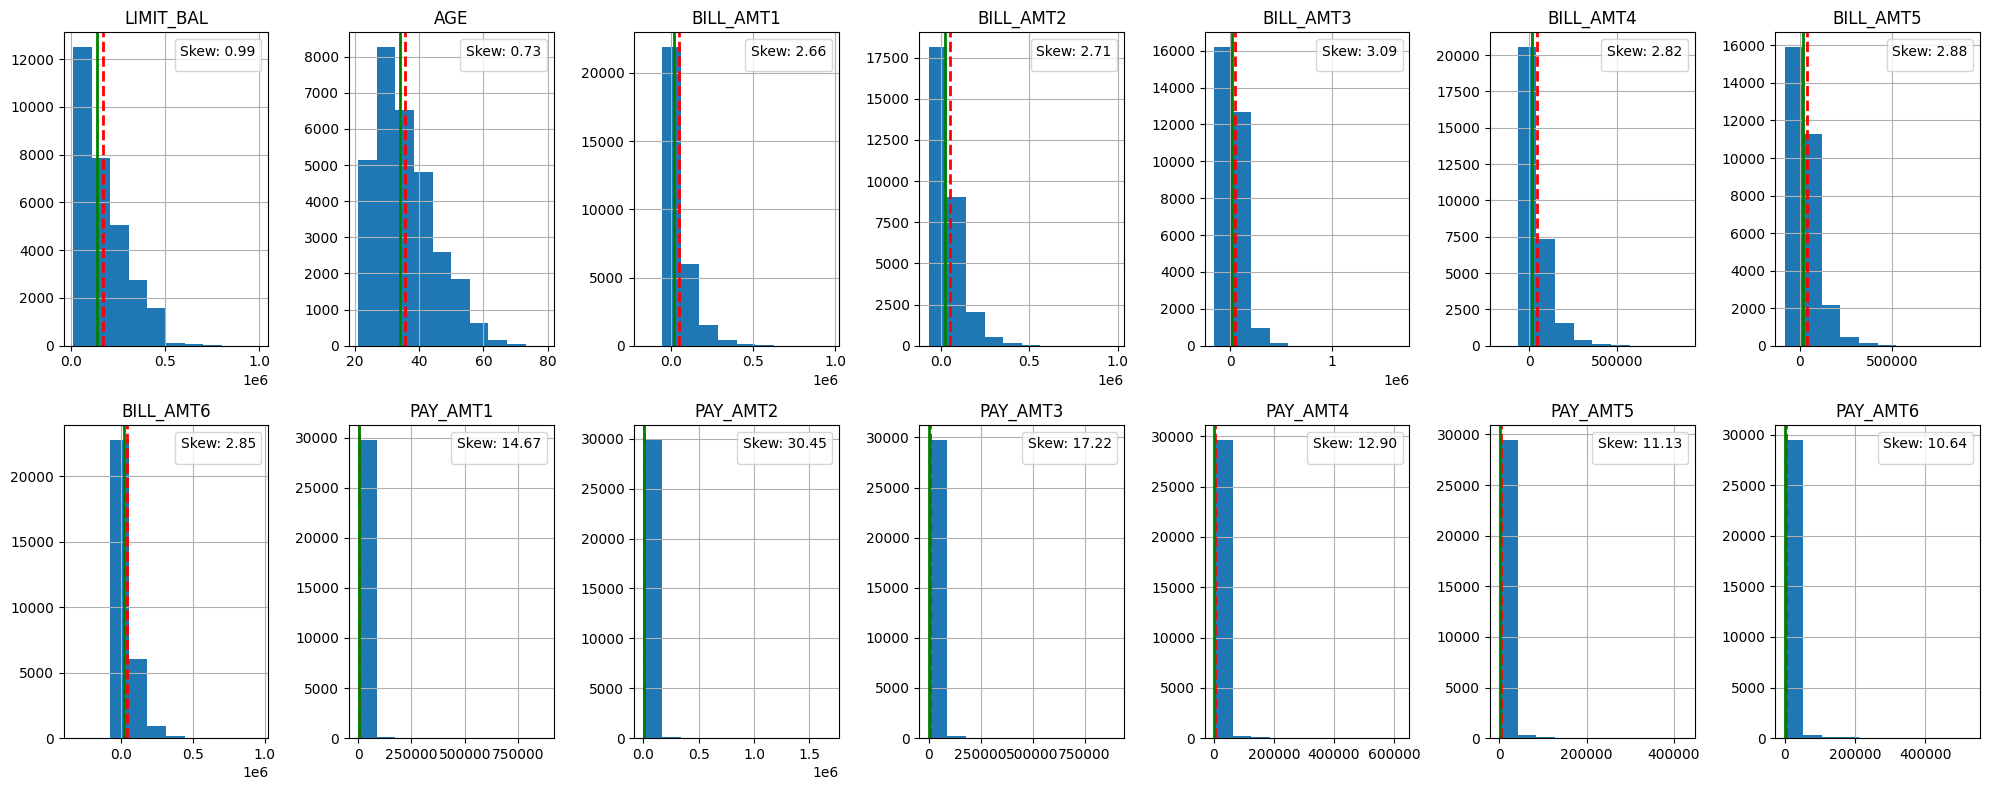

In [382]:
draw_histograms(df, df.select_dtypes(include=[np.number]).columns,2,7)

We can see that almost all the numerical variables are right-skewed, which means they are positively skewed. They contain a few large values that create a long tail on the right, causing the mean to be higher than the median. This can be observed in the plots, where the red dashed line represents the mean and the green line represents the median.

In [383]:
for i in ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']:
    print(i)
    print(df[df[i]<0].shape[0] / df.shape[0])

BILL_AMT1
0.019666666666666666
BILL_AMT2
0.0223
BILL_AMT3
0.021833333333333333
BILL_AMT4
0.0225
BILL_AMT5
0.021833333333333333
BILL_AMT6
0.022933333333333333


In addition, we observe variables such as BILL_AMTN (1–6) containing negative values, which represent around 2% of the dataset. There is no specific information about this situation in the dataset description. For now, we can assume that these values may represent scenarios such as overpayments (customer credit balances), charge reversals or refunds, or certain types of bonuses provided by the bank.

## Data Cleaning

In [384]:
df['EDUCATION'] = df['EDUCATION'].replace({6: 4, 5:4, 0:4})

print(f"P-Value: {chi2_contingency(pd.crosstab(df['EDUCATION'],df['default payment next month'],margins=True).round(3))[1]}")

P-Value: 1.312857313478719e-30


In [385]:
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

print(f"P-Value: {chi2_contingency(pd.crosstab(df['MARRIAGE'],df['default payment next month'],margins=True).round(3))[1]}")

P-Value: 8.879828628366682e-05


In [386]:
df = df.rename(columns={'PAY_0':'PAY_1'})

In [387]:
for i in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    df[i] = df[i].replace({-2:0, -1:0})

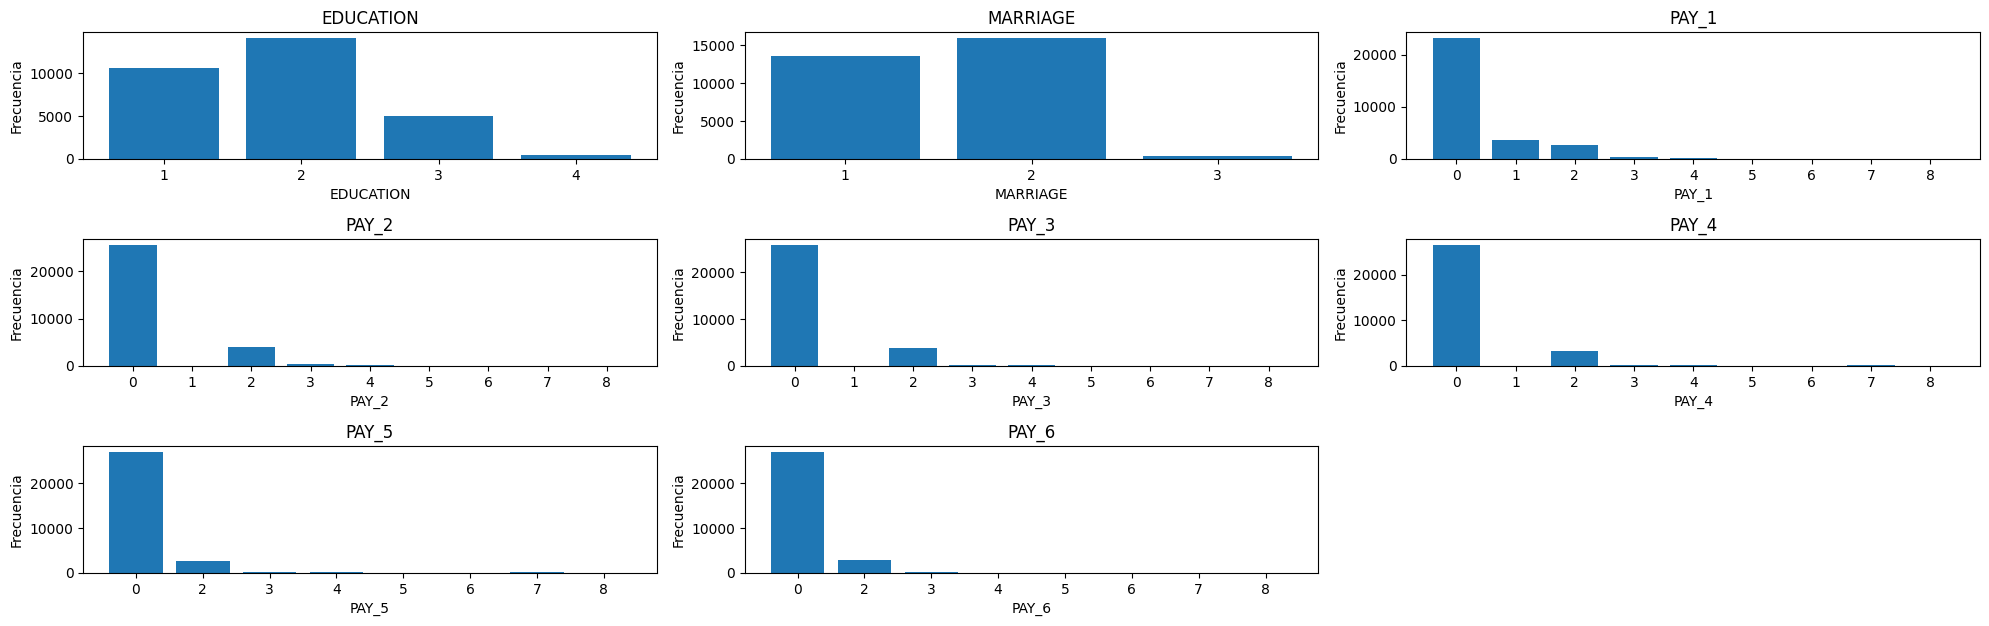

In [388]:
draw_barplots(df,['EDUCATION','MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],4,3)

As mentioned above, in the EDUCATION variable we reassigned categories 6, 5, and 0 to the value 4, and then retested the chi-square contingency as noted earlier. This reduced the p-value from 1.5987086709565762e-27 to 1.312857313478719e-30.

For the MARRIAGE variable, we reassigned category 0 to 3 and repeated the process. In this case, the p-value of the chi-square test did not improve; nonetheless, we will keep this change for interpretability purposes.

We also renamed the PAY_0 variable to PAY_1, as previously mentioned. For the PAY_N variables (1–6), we reassigned categories -2 and -1 to 0. Finally, we can visualize the bar plots of each variable to observe the results.

## Relationship between the target variable and the independent variables

Previously, we applied the chi-square contingency test between variables such as MARRIAGE and EDUCATION and the target variable. In this section, we will go deeper into this analysis by examining the relationships between the independent variables and the target variable.

In [389]:
print(f"P-Value: {chi2_contingency(pd.crosstab(df['MARRIAGE'],df['default payment next month'],margins=True).round(3))[1]}")
pd.crosstab(df['MARRIAGE'],df['default payment next month'],margins=True)

P-Value: 8.879828628366682e-05


default payment next month,0,1,All
MARRIAGE,,,
1,10453,3206,13659
2,12623,3341,15964
3,288,89,377
All,23364,6636,30000


In [390]:
print(f"P-Value: {chi2_contingency(pd.crosstab(df['EDUCATION'],df['default payment next month'],margins=True).round(3))[1]}")
pd.crosstab(df['EDUCATION'],df['default payment next month'],margins=True)

P-Value: 1.312857313478719e-30


default payment next month,0,1,All
EDUCATION,,,
1,8549,2036,10585
2,10700,3330,14030
3,3680,1237,4917
4,435,33,468
All,23364,6636,30000


In [391]:
print(f"P-Value: {chi2_contingency(pd.crosstab(df['SEX'],df['default payment next month'],margins=True).round(3))[1]}")
pd.crosstab(df['SEX'],df['default payment next month'],margins=True)

P-Value: 9.876093788177908e-10


default payment next month,0,1,All
SEX,,,
1,9015,2873,11888
2,14349,3763,18112
All,23364,6636,30000


With this function, we will plot the bar chart of each variable stacked by the target variable. This will serve as a visual aid.

In [392]:
def draw_stacked_barplots(df, variables, target, n_rows, n_cols):
    fig = plt.figure(figsize=(20, 8))
    
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        # Tabla de frecuencias cruzadas
        crosstab = pd.crosstab(df[var_name], df[target])
        
        # Gráfica de barras apiladas
        crosstab.plot(kind="bar", stacked=True, ax=ax, legend=False)
        
        ax.set_title(var_name)
        ax.set_xlabel(var_name)
        ax.set_ylabel("Frecuencia")
    
    # Agregar leyenda una sola vez
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title=target, loc="upper right")
    
    fig.tight_layout()
    plt.show()

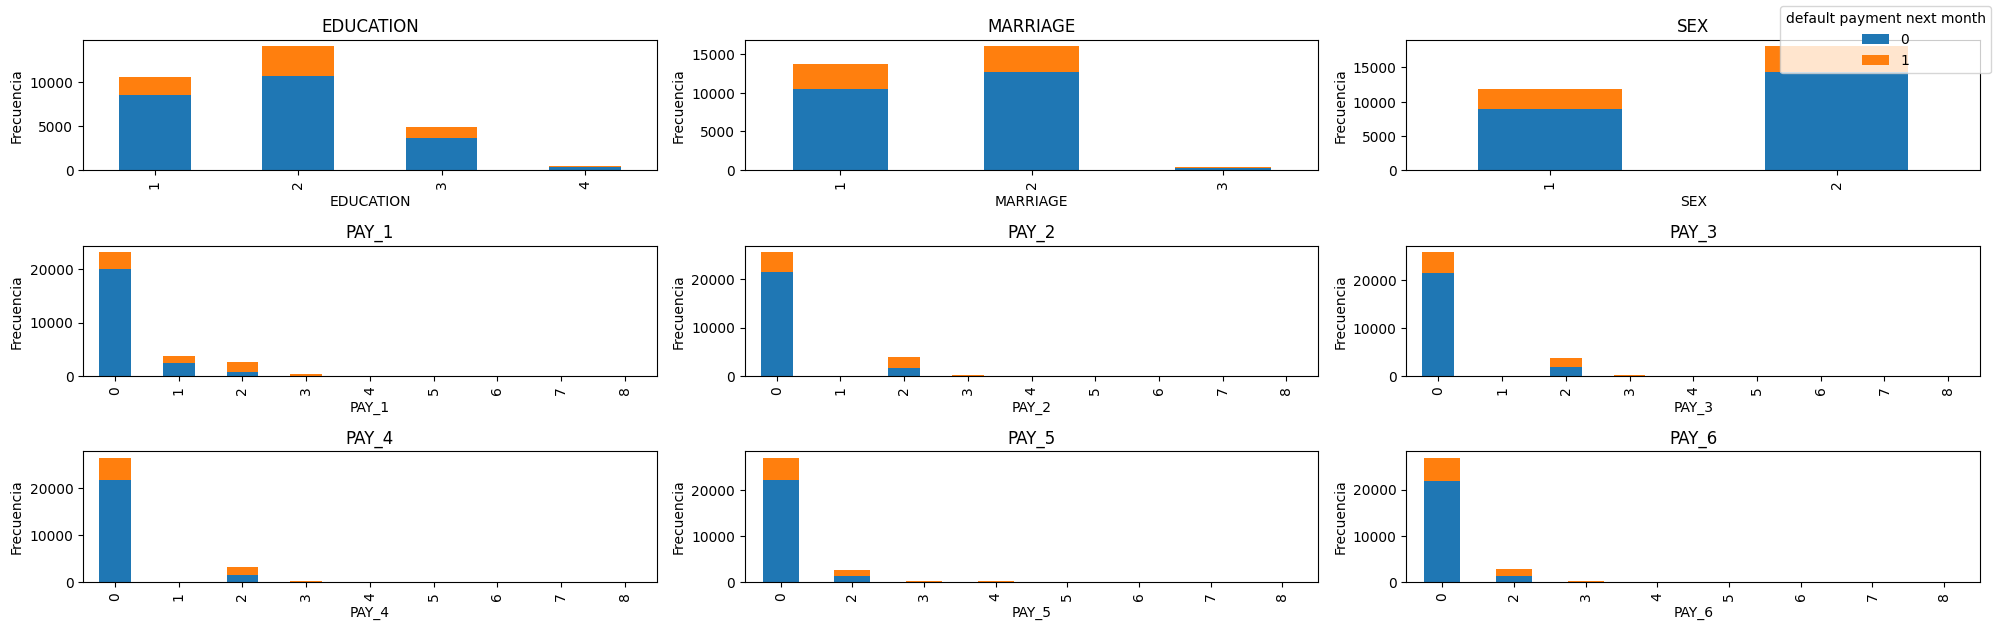

In [393]:
draw_stacked_barplots(df,['EDUCATION','MARRIAGE','SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], "default payment next month",4,3)

In [394]:
for i in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    print(i)
    print(f"P-Value: {chi2_contingency(pd.crosstab(df[i],df['default payment next month'],margins=True).round(3))[1]}")

PAY_1
P-Value: 0.0
PAY_2
P-Value: 0.0
PAY_3
P-Value: 0.0
PAY_4
P-Value: 0.0
PAY_5
P-Value: 0.0
PAY_6
P-Value: 0.0


From the charts and the p-values of the chi-square contingency test, we can conclude that each categorical variable has a relationship with the target variable. Even so, we can take a deeper look at the behavior of some variables with respect to the target variable.

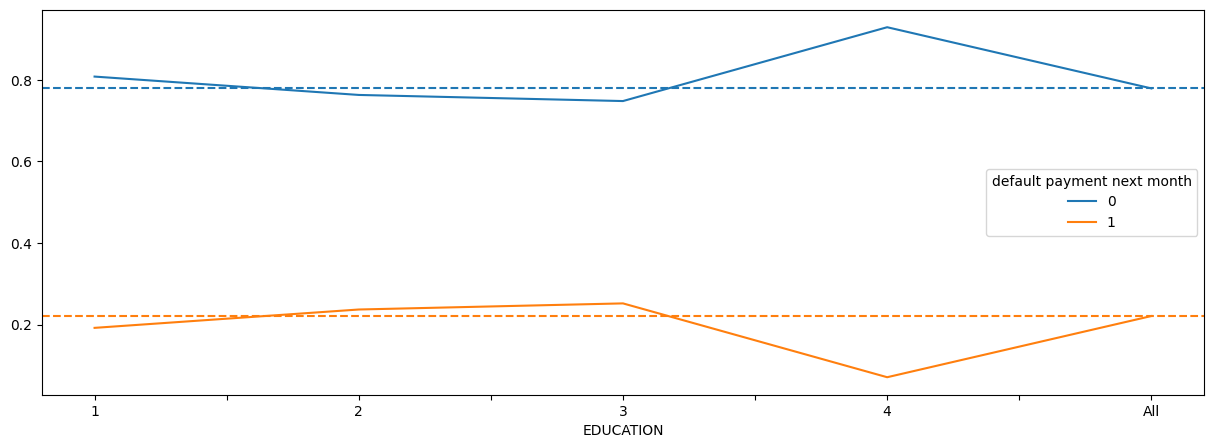

In [395]:
pd.crosstab(df['EDUCATION'], df['default payment next month'], margins=True, normalize=0).round(3).plot(figsize=(15, 5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

In this case, with the EDUCATION variable, the plot above shows that people in the 'graduate school' or 'others' categories are less likely to incur in default payment the following month. This is reflected by the blue line (representing those who did not default), which is above the global mean. Conversely, people in the 'university' or 'high school' categories are more likely to incur in default payment.

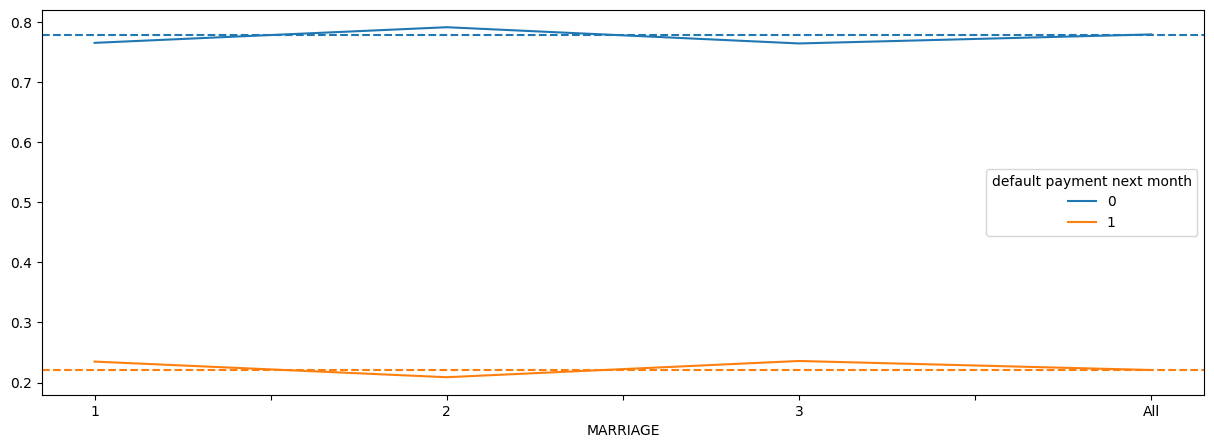

In [396]:
pd.crosstab(df['MARRIAGE'], df['default payment next month'], margins=True, normalize=0).round(3).plot(figsize=(15, 5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

For the MARRIAGE variable, individuals who are single are less likely to incur in default payment, though not by a significant margin.

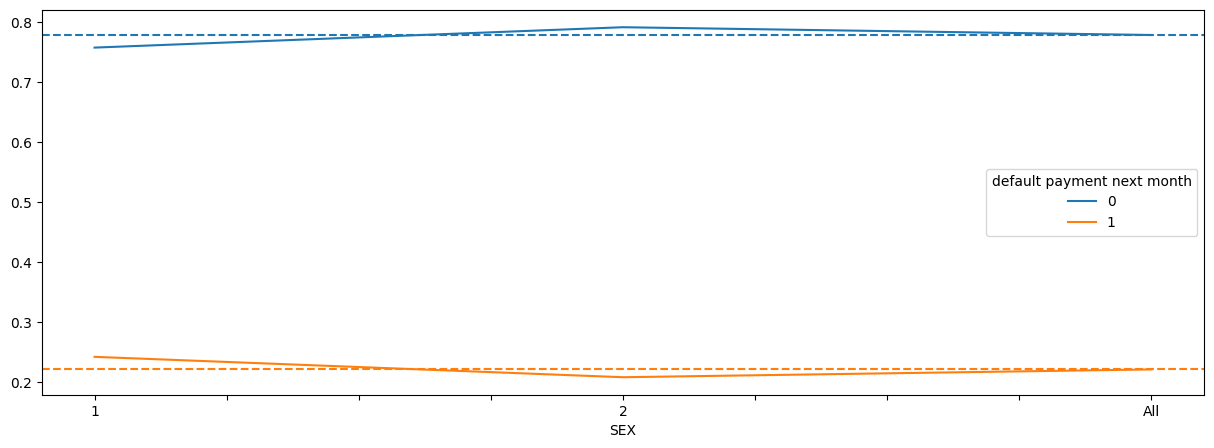

In [397]:
pd.crosstab(df['SEX'], df['default payment next month'], margins=True, normalize=0).round(3).plot(figsize=(15, 5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

With respect to the SEX variable, women have a lower probability of defaulting, though not by a significant margin.

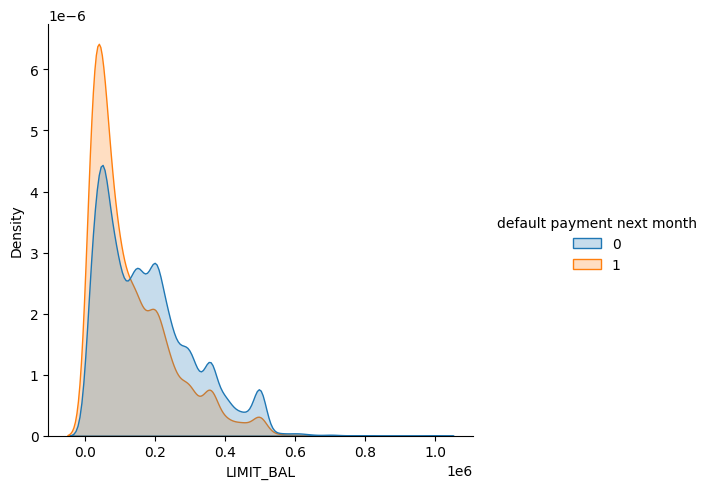

In [398]:
sns.displot(x=(df['LIMIT_BAL']), kind="kde", fill=True, hue=df['default payment next month'], common_norm=False)
plt.show()

For the LIMIT_BAL variable (which, as we recall, represents the amount of given credit), we can observe in the plot above that for lower credit amounts, there is a higher proportion of people who incur in default payment. In contrast, for higher credit amounts, there appears to be a range where people are less likely to default.

In [399]:
print(f_oneway(df.loc[df["default payment next month"]==0,['LIMIT_BAL']], df.loc[df["default payment next month"]==1,['LIMIT_BAL']])[1])

[1.30224395e-157]


Building on the previous analysis, we applied the `f_oneway` function to perform the ANOVA test, which is a statistical method used to determine whether there are statistically significant differences between the means of different groups. Recall that the ANOVA test is based on the following hypotheses:

* $H_0$: The population means of all groups are equal.

Given the p-value obtained, we can reject the null hypothesis.

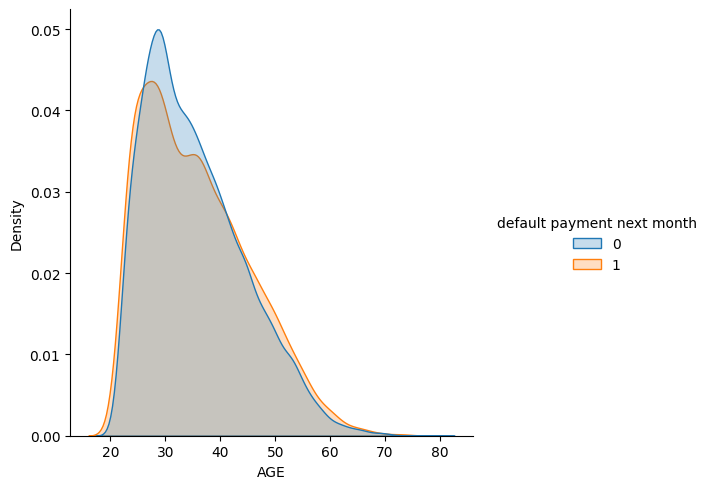

In [400]:
sns.displot(x=(df['AGE']), kind="kde", fill=True, hue=df['default payment next month'], common_norm=False)
plt.show()

For the AGE variable, we can observe three approximate ranges. In the first one, around 18–27 years, there is no clear difference between good and bad clients. In the second range, approximately 28–44 years, we can see a higher proportion of clients who did not default on their payment. Beyond that range, the proportion of people who default increases.

## Split the dataset into Train and Test Samples

For these two numerical variables (LIMIT_BAL and AGE), we will use binning to group them into categories, but first, we'll split the dataset into the train and test samples.

In [401]:
df_train, df_test = train_test_split(df,stratify=df["default payment next month"], test_size=.25, random_state=845)

In [402]:
yT_0_train = df_train['default payment next month'].value_counts(normalize=True)[0]
yT_1_train = df_train['default payment next month'].value_counts(normalize=True)[1]
print(yT_0_train, yT_1_train)

0.7788 0.2212


In [403]:
yT_0_test = df_test['default payment next month'].value_counts(normalize=True)[0]
yT_1_test = df_test['default payment next month'].value_counts(normalize=True)[1]
print(yT_0_test, yT_1_test)

0.7788 0.2212


We can see that the proportion of 1s and 0s in the target variable persists across the train and test samples.

### LIMIT_BAL - WoE

In [404]:
variable="LIMIT_BAL"
X=df_train[variable].values
Y=df_train['default payment next month'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(X, Y)

binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 25000.00)",1867,0.082978,1188,679,0.363685,-0.699282,0.047992,0.005880
1,"[25000.00, 45000.00)",1397,0.062089,903,494,0.353615,-0.6555,0.031283,0.003842
2,"[45000.00, 75000.00)",3675,0.163333,2692,983,0.267483,-0.251256,0.011026,0.001375
3,"[75000.00, 105000.00)",2429,0.107956,1838,591,0.243310,-0.12407,0.001719,0.000215
4,"[105000.00, 145000.00)",2113,0.093911,1622,491,0.232371,-0.063716,0.000388,0.000048
5,"[145000.00, 205000.00)",3823,0.169911,3153,670,0.175255,0.290145,0.013148,0.001638
6,"[205000.00, 245000.00)",1923,0.085467,1593,330,0.171607,0.315595,0.007765,0.000967
7,"[245000.00, 305000.00)",1877,0.083422,1582,295,0.157166,0.420783,0.013048,0.001619
8,"[305000.00, 365000.00)",1579,0.070178,1346,233,0.147562,0.495167,0.014854,0.001838
9,"[365000.00, inf)",1817,0.080756,1606,211,0.116125,0.770957,0.037974,0.004633


Remember the WoE formula, and keep in mind that when the number of events (default payments equal to 1) is higher, the WoE will be lower, and vice versa.
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

Based on the WoE values for each bin, we can see that the WoE is negative for the first bins, which means there's a higher rate of default payment. For example, credit amounts less than 25,000 have a WoE of -0.69. As the credit amount increases, the WoE increases, indicating a lower rate of default payment. This is consistent with the behavior we previously observed in the density plot.

In [405]:
binning_table.analysis(pvalue_test="chi2")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23500718
    IV (Jeffrey)             0.17919750
    JS (Jensen-Shannon)      0.02205349
    Hellinger                0.02222458
    Triangular               0.08689140
    KS                       0.18018241
    HHI                      0.11247180
    HHI (normalized)         0.03178742
    Cramer's V               0.17656738
    Quality score            0.02007425

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1     0.351975 5.529971e-01  0.723979 2.760210e-01
        1      2    36.381585 1.622288e-09  1.000000 4.451463e-10
        2      3     4.465367 3.458866e-02  0.983489 1.651099e-02
        3      4     0.745115 3.880272e-01  0.806459 1.935412e-01
        4      5    28.216795 1.084594e-07  1.00

The statistics above show an Information Value (IV) of 0.179, which indicates that the variable has an average influence on the target variable. In addition, the Gini Index is 23.5% (a metric of concentration), which suggests the variable has reasonable predictive power, so we can keep it for our model.

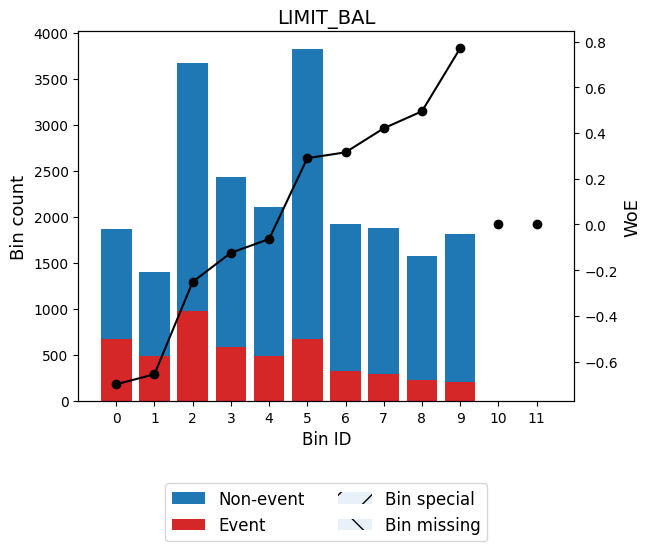

In [406]:
binning_table.plot(metric="woe")

The bar plot shows how, as the bin increases, the default events decrease and the WoE increases.

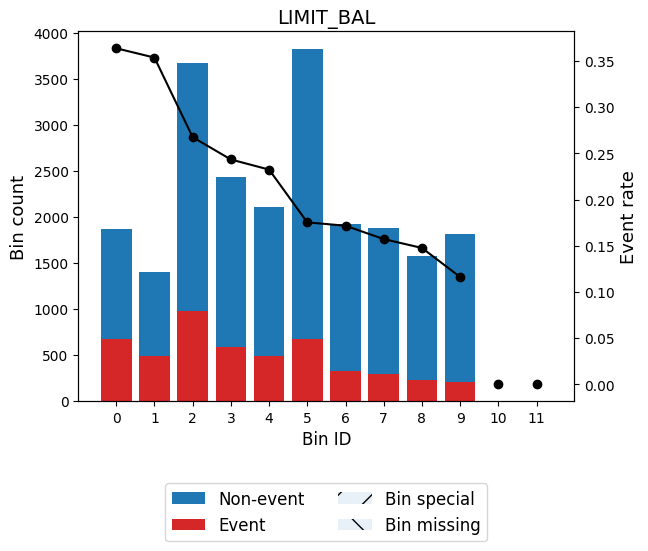

In [407]:
binning_table.plot(metric="event_rate")

Consequently, this bar plot shows a decrease in the event rate.

In [408]:
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index()

-0.699282    1867
-0.655500    1397
-0.251256    3675
-0.124070    2429
-0.063716    2113
 0.290145    3823
 0.315595    1923
 0.420783    1877
 0.495167    1579
 0.770957    1817
Name: count, dtype: int64

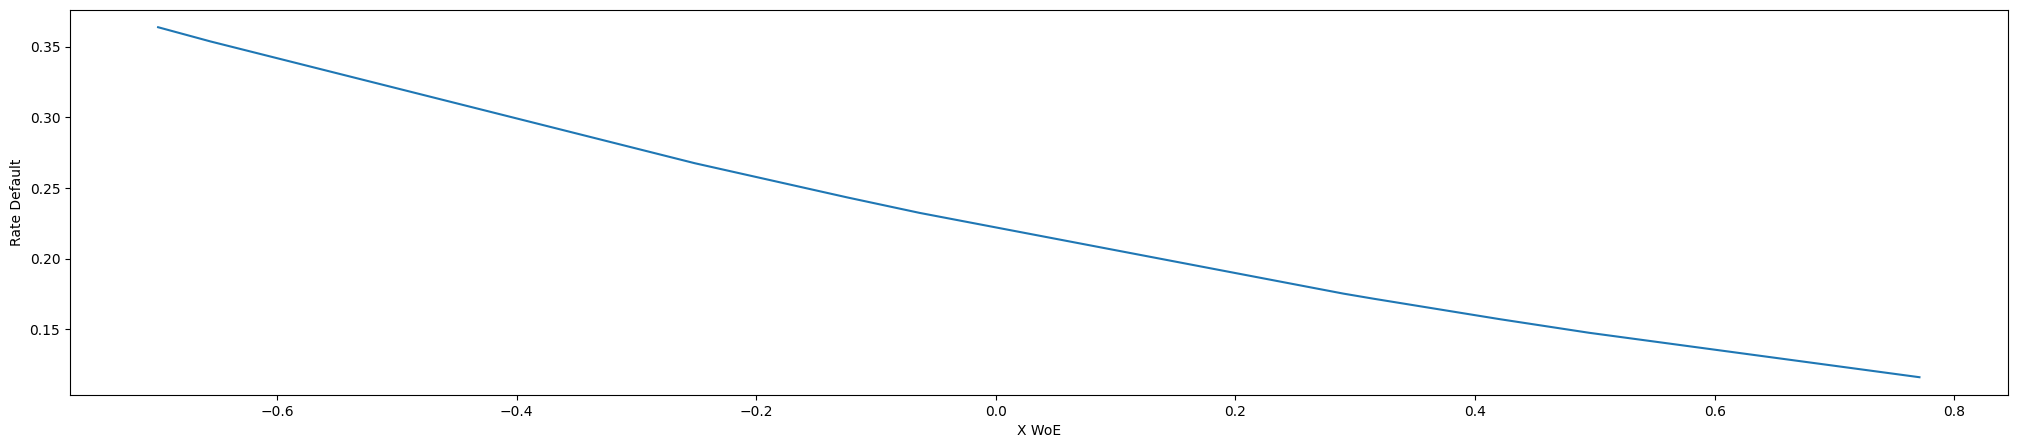

In [409]:
plt.figure(figsize=(25,5))
plt.plot(pd.crosstab(x_woe,Y,normalize=0).iloc[:,1])
plt.xlabel("X WoE")
plt.ylabel("Rate Default")
plt.show()

The line plot shows that as the WoE increases, the default rate decreases.

### AGE - WoE

We can perform a similar analysis on the AGE variable.

In [410]:
variable="AGE"
X=df_train[variable].values
Y=df_train['default payment next month'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(X, Y)

binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 23.50)",1166,0.051822,849,317,0.271870,-0.27353,0.004169,0.000520
1,"[23.50, 25.50)",1750,0.077778,1298,452,0.258286,-0.203789,0.003412,0.000426
2,"[25.50, 28.50)",3071,0.136489,2442,629,0.204819,0.097754,0.001269,0.000159
3,"[28.50, 31.50)",3200,0.142222,2585,615,0.192188,0.177172,0.004244,0.000530
4,"[31.50, 33.50)",1696,0.075378,1381,315,0.185731,0.219304,0.003403,0.000425
5,"[33.50, 35.50)",1684,0.074844,1339,345,0.204869,0.097447,0.000691,0.000086
6,"[35.50, 45.50)",6466,0.287378,5050,1416,0.218992,0.012865,0.000047,0.000006
7,"[45.50, 49.50)",1491,0.066267,1112,379,0.254192,-0.182308,0.002314,0.000289
8,"[49.50, inf)",1976,0.087822,1467,509,0.257591,-0.20016,0.003713,0.000463
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [411]:
binning_table.analysis(pvalue_test="chi2")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08445127
    IV (Jeffrey)             0.02326299
    JS (Jensen-Shannon)      0.00290271
    Hellinger                0.00290529
    Triangular               0.01159025
    KS                       0.03198607
    HHI                      0.15356480
    HHI (normalized)         0.06892128
    Cramer's V               0.06378918
    Quality score            0.00205900

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     0.664992 0.414803  0.791817  0.208183
        1      2    18.319777 0.000019  0.999993  0.000007
        2      3     1.572412 0.209857  0.895265  0.104735
        3      4     0.300302 0.583693  0.710166  0.289834
        4      5     1.969587 0.160492  0.079868  0.920132
        5      6     1.5

Technically, based on the Information Value (IV) and Gini Index, the AGE variable (or its WoE) can be used as a predictive variable, but its predictive power is lower than that of the LIMIT_BAL variable.

### WoE across all the variables

We will apply the WoE transformation to all numerical and categorical variables. Based on the Information Value (IV), we will select variables with a minimum IV of 0.02.

In [412]:
selection_criteria = {
    "iv": {"min": 0.02} 
}

In [413]:
Y = df_train['default payment next month'].values
X = df_train[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
Y_test = df_test['default payment next month'].values
X_test = df_test[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [414]:
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)

df_train_binned = binning_process.fit(X, Y)

df_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
3,MARRIAGE,categorical,OPTIMAL,False,2,0.005531,0.000691,0.037138,0.015292
12,BILL_AMT2,numerical,OPTIMAL,False,6,0.006178,0.000771,0.035838,0.000332
1,SEX,categorical,OPTIMAL,False,2,0.00637,0.000796,0.039225,0.016952
13,BILL_AMT3,numerical,OPTIMAL,False,4,0.007202,0.000898,0.032351,0.016052
11,BILL_AMT1,numerical,OPTIMAL,False,5,0.011551,0.001438,0.045481,0.018653
14,BILL_AMT4,numerical,OPTIMAL,False,5,0.013917,0.001729,0.046374,0.034817
15,BILL_AMT6,numerical,OPTIMAL,False,5,0.015238,0.001893,0.048923,0.045163
2,EDUCATION,categorical,OPTIMAL,True,3,0.020909,0.00261,0.075042,0.065883
4,AGE,numerical,OPTIMAL,True,9,0.023263,0.002903,0.084451,0.002059
20,PAY_AMT5,numerical,OPTIMAL,True,6,0.094481,0.011676,0.165995,0.266515


In [415]:
df_train_binned.information()

optbinning (Version 0.20.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                  22500
    Number of variables                   22
    Target type                       binary

    Number of numerical                   13
    Number of categorical                  9
    Number of selected                    15

  Time                                2.0546 sec



We can see that of the 22 predictive variables, 15 were selected for the model.

In [416]:
dt_train_woe=df_train_binned.transform(X, metric="woe")
dt_train_woe.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
12853,0.770957,0.191717,-0.182308,0.566116,-1.491958,0.309020,0.257626,0.221866,0.209579,-0.678813,1.099042,-0.540847,-0.471451,0.698839,-0.356290
10908,0.290145,0.191717,0.177172,0.566116,0.373664,-1.360645,0.257626,0.221866,0.209579,0.432088,-0.566613,-0.540847,0.859714,-0.064064,-0.356290
9736,-0.063716,0.191717,0.177172,0.566116,0.373664,0.309020,0.257626,0.221866,0.209579,0.027250,-0.069157,0.005420,0.104711,-0.064064,-0.035005
8726,-0.124070,-0.074925,-0.273530,0.566116,0.373664,0.309020,0.257626,0.221866,0.209579,-0.029263,-0.069157,-0.016140,-0.048931,0.076810,-0.004907
27017,-0.124070,-0.178503,0.012865,0.566116,0.373664,0.309020,0.257626,0.221866,0.209579,0.027250,0.069978,0.005420,0.199928,0.164355,0.088630


## The Logistic Model

In [417]:
estimator = LogisticRegression()

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

,binning_process,"BinningProces..., 'PAY_AMT6'])"
,estimator,LogisticRegression()
,scaling_method,'pdo_odds'
,scaling_method_params,"{'odds': 50, 'pdo': 40, 'scorecard_points': 600}"
,intercept_based,False
,reverse_scorecard,False
,rounding,False
,verbose,False
,variable_names,"['LIMIT_BAL', 'SEX', ...]"
,max_n_prebins,20
,min_prebin_size,0.05


In [418]:
tarjeta.table().head(60)

,Variable,Bin,Points
0,LIMIT_BAL,"(-inf, 25000.0000)",17.474590
1,LIMIT_BAL,"[25000.0000, 45000.0000)",18.243799
2,LIMIT_BAL,"[45000.0000, 75000.0000)",25.346037
3,LIMIT_BAL,"[75000.0000, 105000.0000)",27.580607
4,LIMIT_BAL,"[105000.0000, 145000.0000)",28.640976
5,LIMIT_BAL,"[145000.0000, 205000.0000)",34.858030
6,LIMIT_BAL,"[205000.0000, 245000.0000)",35.305161
7,LIMIT_BAL,"[245000.0000, 305000.0000)",37.153233
8,LIMIT_BAL,"[305000.0000, 365000.0000)",38.460106
9,LIMIT_BAL,"[365000.0000, inf)",43.305512


Above, we can see the points given by belong in a specific category of each variable.

### The model on the training dataset

In [419]:
Y_pred=tarjeta.predict_proba(X)[:,1]

Y_pred.mean().round(4)


np.float64(0.2212)

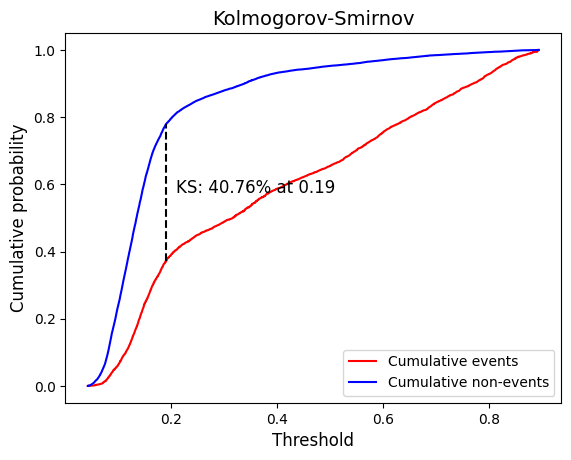

In [420]:
plot_ks(Y, Y_pred)

The Kolmogorov-Smirnov (KS) shows a maximum value of 40.76% at the 0.19 threshold, which indicates moderate model discrimination.

Remember: The F1-score is an evaluation metric that mixes precision and recall into one score. This is especially helpful when the classes are imbalanced.

The cutoff point that maximizes the F1-score is:  0.27
and the maximum is reached at  0.531


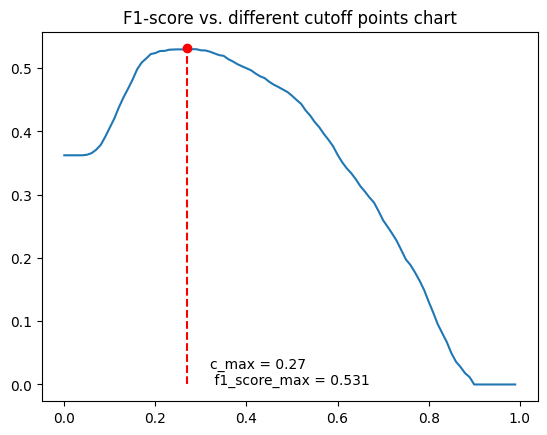

In [421]:
c=np.arange(0,1,0.01)

f1_score_ = [f1_score(df_train["default payment next month"],np.multiply(Y_pred>c_,1)) for c_ in c]

c_max = c[np.argmax(f1_score_)]
print("The cutoff point that maximizes the F1-score is: ", c_max)
print("and the maximum is reached at ", np.max(f1_score_).round(3))

plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("F1-score vs. different cutoff points chart")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

c_maxF1=c_max

The F1-score shows a maximum value of 0.531 at the 0.27 threshold.

The cutoff point that maximizes the Youden's J statistic is:  0.19
and the maximum is reached at  0.408


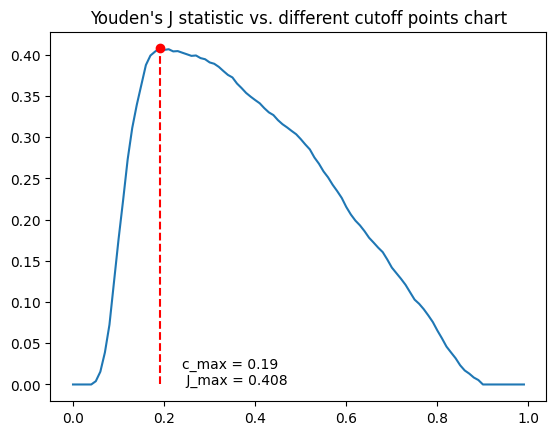

In [422]:
c=np.arange(0,1,0.01)

J= [balanced_accuracy_score(df_train["default payment next month"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]

c_max = c[np.argmax(J)]
print("The cutoff point that maximizes the Youden's J statistic is: ", c_max)
print("and the maximum is reached at ", np.max(J).round(3))

plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Youden's J statistic vs. different cutoff points chart")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

The Youden's J statistic shows a maximum value of 0.408 at the 0.19 threshold.

In [423]:
Prob_Corte=df['default payment next month'].value_counts(normalize=True)[1]
# Prob_Corte=c_maxF1
print('Selected threshold:', Prob_Corte.round(2),'\n',
      'Average frecuency of events (y=1):', df['default payment next month'].value_counts(normalize=True)[1], '\n',
      'F1-score shows a maximum value at:', c_maxF1, '\n',
      "Youden's J statistic shows a maximum value at:", c_max)

Selected threshold: 0.22 
 Average frecuency of events (y=1): 0.2212 
 F1-score shows a maximum value at: 0.27 
 Youden's J statistic shows a maximum value at: 0.19


In this case, we will set the threshold at 0.22, which is the event rate in the dataset.

In [424]:
df_train["Y_pronostico"]=np.multiply(Y_pred>Prob_Corte,1)

In [425]:
pd.crosstab(df_train["default payment next month"],df_train["Y_pronostico"])

Y_pronostico,0,1
default payment next month,,
0,14443,3080
1,2094,2883


Remember the precision:
* $Positive\ Precision = \frac{True\ Positives}{True\ Positives + False\ Positives}$

* $Negative\ Precision = \frac{True\ Negatives}{True\ Negatives + False\ Negatives}$

In [426]:
pd.crosstab(df_train["default payment next month"],df_train["Y_pronostico"],margins=True, normalize=1).round(3)


Y_pronostico,0,1,All
default payment next month,,,
0,0.873,0.517,0.779
1,0.127,0.483,0.221


On the training set, the precision for the default class is 48%, meaning that of all predicted defaults, 48% were correct. The precision for the non-default class is 87%, meaning that of all predicted non-defaults, 87% were correct.

Remember:
* $Sensibility = \frac{True\ Positives}{False\ Negatives + True\ Positives}$

* $Specificity = \frac{True\ Negatives}{Negatives\ Negatives + False\ Positives}$


In [427]:
pd.crosstab(df_train["default payment next month"],df_train["Y_pronostico"],margins=True, normalize=0).round(3)


Y_pronostico,0,1
default payment next month,,
0,0.824,0.176
1,0.421,0.579
All,0.735,0.265


On the training set, the model's sensitivity is 57.9%, meaning it correctly identifies 57.9% of all actual default payments.

The specificity is 82.4%, which means the model correctly identifies 82.4% of all actual non-default payments.

In [428]:
print(f"F1-Score {f1_score(df_train["default payment next month"],df_train["Y_pronostico"])}" )

F1-Score 0.5270566727605119


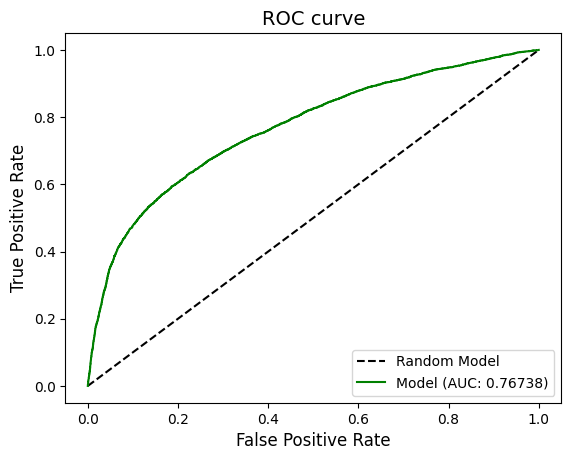

In [429]:
plot_auc_roc(Y,Y_pred)

On the training set, the Area Under the Curve (AUC) is 0.76. This means there is a 76% probability that the model will correctly distinguish between a randomly selected positive case and a randomly selected negative case.

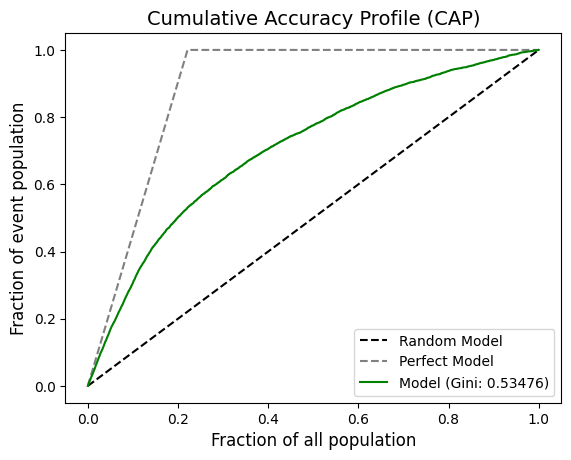

In [430]:
plot_cap(Y, Y_pred)

With a Gini Index of 0.53, the model demonstrates a good level of predictive power.

### The model on the test dataset

We will now apply the test dataset to the model to see how it performs on unseen data.

In [431]:
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

Y_test_pred.mean().round(5)

np.float64(0.22116)

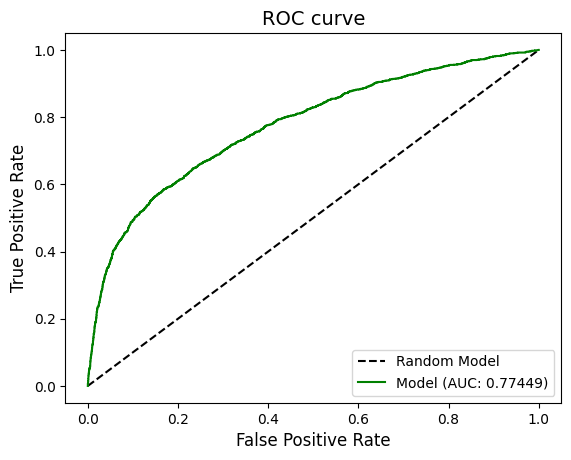

In [432]:
plot_auc_roc(Y_test,Y_test_pred)


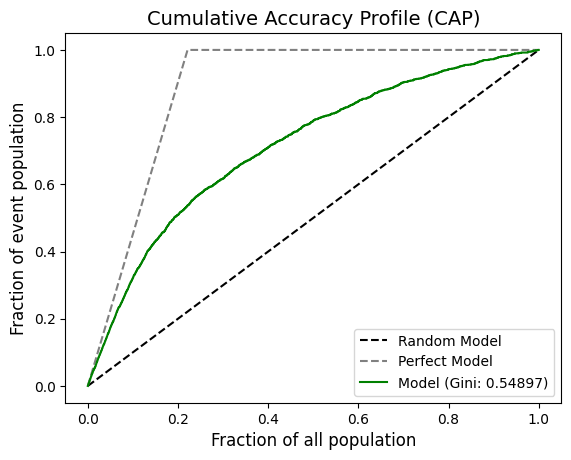

In [433]:
plot_cap(Y_test,Y_test_pred)

When evaluated on the test dataset, the AUC and Gini's Index improve slightly, in contrast to their values on the training dataset.

In [434]:
df_test["Y_pronostico"]=np.multiply(Y_test_pred>0.22,1)

print("\n Precision:\n", pd.crosstab(df_test["default payment next month"],df_test["Y_pronostico"],margins=True, normalize=1).round(3))

print("\n Recall :\n",pd.crosstab(df_test["default payment next month"],df_test["Y_pronostico"],margins=True, normalize=0).round(3))

print("\n f1-score:",f1_score(df_test["default payment next month"],df_test["Y_pronostico"]))


 Precision:
 Y_pronostico                    0      1    All
default payment next month                     
0                           0.876  0.511  0.779
1                           0.124  0.489  0.221

 Recall :
 Y_pronostico                    0      1
default payment next month              
0                           0.826  0.174
1                           0.412  0.588
All                         0.734  0.266

 f1-score: 0.5339539978094195


When evaluated on the test dataset, both Precision and Recall show a slight improvement compared to their values on the training dataset.

In [435]:
score = tarjeta.score(X)

print("Minimum score: ", score.min().round(2))
print("Maximum score: ",score.max().round(2))
print("Average score : ",score.mean().round(2))  


Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)

score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

print("Manual minimum score calculation: ",score2.min().round(2))
print("Manual maximum score calculation: ",score2.max().round(2))
print("Manual average score calculation: ",score2.mean().round(2))

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])


Minimum score:  251.23
Maximum score:  553.63
Average score :  458.81
Manual minimum score calculation:  251.23
Manual maximum score calculation:  553.63
Manual average score calculation:  458.81


In [436]:
Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("The cutoff probability of: ", Prob_Corte, " is equivalent to a cutoff score of: ", Score_Corte.round(2) )


The cutoff probability of:  0.2212  is equivalent to a cutoff score of:  446.88


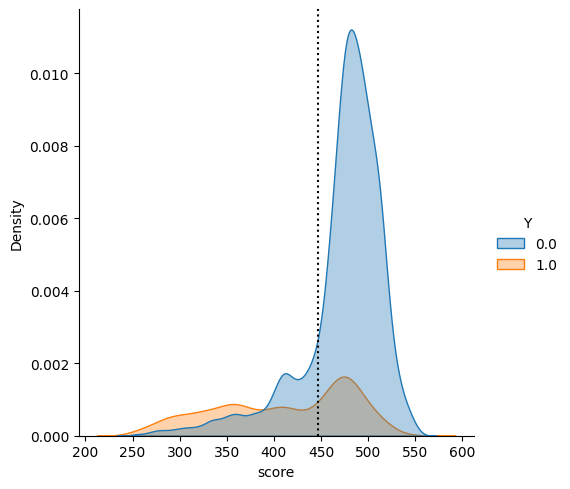

In [437]:
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True, common_norm=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

## Conclusions

The objective of this analysis was to explore, clean, and prepare a dataset to predict the risk of payment default on credit accounts. We identified the relationship between various variables and the payment behavior of clients.

Key Findings from Data Exploration:
* Education: Clients with a 'Graduate School' or 'Others' education level were found to have a lower propensity for defaulting on payments.

* Credit Limit (LIMIT_BAL): A clear trend was observed: the lower the credit limit, the higher the probability of default. This trend reversed as the credit limit increased.

* Age (AGE): The age variable also proved to be a relevant factor, with certain age ranges showing a higher tendency to not default.

**Predictive Model Results and Limitations**

For the predictive model, we used a Weight of Evidence (WoE) approach to build a Logistic Regression model and a ScoreCard. The results revealed the following information:

* Model Performance: The model shows acceptable performance, with an AUC of 0.77. However, its ability to identify clients who will actually default (recall) is limited, reaching only 58%. On the other hand, its ability to identify clients who will not default is robust, with an 82% accuracy rate.

* Business Implications: While the model is effective at identifying low-risk clients—which helps prevent the loss of potential clients—its limited ability to detect those who will default could result in financial losses for the banking institution.

* Implementation Constraints: Since the model required historical payment variables, its application is limited to existing clients. It is not suitable for estimating the risk of new clients who do not yet have a credit history with the institution.